In [71]:
import tensorflow as tf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
def convert_to_one_hot(label,depth=10):
    encoded=tf.one_hot(label,depth,axis=0)
    
    return encoded

In [227]:
def model_build(layers):
    bias=tf.keras.initializers.HeNormal(seed=1)
    units=[25,15,50,10]
    for i in range(layers):
        if i==0:
            model.add(tf.keras.layers.Dense(units[i],activation="relu",kernel_initializer="he_normal",use_bias=True,bias_initializer=bias,input_shape=(784,)))
        elif i>0 and i!=layers-1:
            model.add(tf.keras.layers.Dense(units[i],activation="relu",kernel_initializer="he_normal",use_bias=True,bias_initializer=bias))
        elif i==layers-1:
            model.add(tf.keras.layers.Dense(units[i],activation="softmax",kernel_initializer="he_normal",use_bias=True,bias_initializer=bias))
            

In [239]:
def model_run(x,y,learning_rate=0.000001,num_epochs=1500,batchSize=16,show_costs=1):
     optimizer=tf.keras.optimizers.Adam(learning_rate)
     model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=['accuracy'])
     learning=model.fit(x,y,epochs=num_epochs,batch_size=batchSize,verbose=show_costs)
     
     return learning

In [229]:
def plot(learning):
    #Plotting Loss vs epochs
    plt.plot(learning.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.title("Learning Curve")
    plt.show()
    
    #Plotting Accuracy vs epochs
    plt.plot(learning.history['accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.title("Accuracy Improvement")
    plt.show()    

In [230]:
ds=pd.read_csv("train.csv")
pred=pd.read_csv("test.csv")

In [231]:
x=ds.drop('label',axis=1)
y=ds['label']

In [232]:
x_train=np.array(x/255) #normalization
y_train=(np.array(convert_to_one_hot(y))).reshape((42000,10)) #One hot labels

In [233]:
#Converting to float

x_train=x_train.astype('float32')
y_train=y_train.astype('float32')

In [234]:
model=tf.keras.Sequential()

In [235]:
model_build(4)

In [240]:

learning=model_run(x_train,y_train)


Epoch 1/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2934 - accuracy: 0.0900
Epoch 2/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2934 - accuracy: 0.0896
Epoch 3/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2934 - accuracy: 0.0897
Epoch 4/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2934 - accuracy: 0.0897
Epoch 5/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2933 - accuracy: 0.0895
Epoch 6/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2933 - accuracy: 0.0896
Epoch 7/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2933 - accuracy: 0.0895
Epoch 8/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2933 - accuracy: 0.0896
Epoch 9/1500
2625/2625 [==============================] - 3s 1ms/step - loss: 2.2933 - accuracy: 0.0895
Epoch 10/1500
2625/2625 [==============================] - 3s 1m

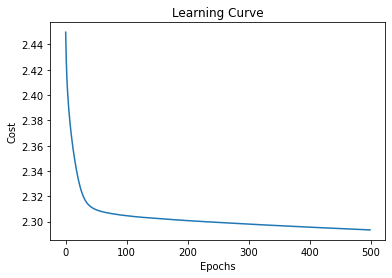

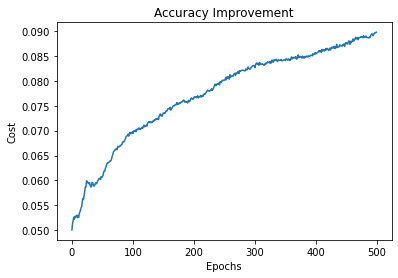

In [237]:
plot(learning)

In [238]:
model.get_weights()

[array([[ 0.08077753, -0.09302145, -0.03473372, ..., -0.011432  ,
         -0.04389671, -0.01384219],
        [-0.08971988,  0.01679308, -0.00133091, ...,  0.05541172,
         -0.07261758,  0.01185559],
        [ 0.02111696, -0.00398182, -0.04519856, ..., -0.00506861,
          0.01190172, -0.0168996 ],
        ...,
        [ 0.06602947, -0.03380609, -0.04752761, ..., -0.01743461,
          0.10235165, -0.10378603],
        [ 0.01564213, -0.00468411, -0.02750318, ...,  0.0952134 ,
          0.08153423,  0.01033286],
        [ 0.07359992,  0.03184235, -0.09953143, ..., -0.0115258 ,
         -0.0511943 ,  0.0583275 ]], dtype=float32),
 array([-0.07608873, -0.05646446,  0.0512398 , -0.21158862,  0.32620782,
        -0.07467962, -0.24947405,  0.6522847 , -0.19690424, -0.24976131,
        -0.1264733 ,  0.03847339, -0.15015607,  0.12644376,  0.30935353,
         0.16870537,  0.19042242, -0.00922835,  0.00842005,  0.5136679 ,
        -0.1383119 ,  0.18558958, -0.01779874, -0.424494  ,  0.113